# Fuzzy Logic Control of a Quadrotor

### Importing needed libraries

In [584]:
import skfuzzy as fuzz
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D

import control.matlab as mt

from IPython.display import clear_output
from IPython.display import display
import ipywidgets as widgets

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [585]:
sin = np.sin
cos = np.cos

### Quadrotor Model

In [616]:
class QuadRotor:
    def __init__(self):
        self.Ix = 0.007
        self.Iy = 0.007
        self.Iz = 0.012
        self.Jr = 6.5e-5
        self.b  = 4.13e-5
        self.d  = 8.5e-7
        self.l  = 0.17
        self.m  = 0.68
        self.g  = 9.81
        self.reset()
        
    def reset(self):
        self.time= np.zeros([0])
        self.x   = np.zeros([0])
        self.y   = np.zeros([0])
        self.z   = np.zeros([0])
        self.Φ   = np.zeros([0])
        self.Θ   = np.zeros([0])
        self.Ψ   = np.zeros([0])
        self.xd  = np.zeros([0])
        self.yd  = np.zeros([0])
        self.zd  = np.zeros([0])
        self.Φd  = np.zeros([0])
        self.Θd  = np.zeros([0])
        self.Ψd  = np.zeros([0])
        self.xdd = np.zeros([0])
        self.ydd = np.zeros([0])
        self.zdd = np.zeros([0])
        self.Φdd = np.zeros([0])
        self.Θdd = np.zeros([0])
        self.Ψdd = np.zeros([0])
        
        self.IMU_xd  = np.zeros([0])
        self.IMU_yd  = np.zeros([0])
        self.IMU_zd  = np.zeros([0])
        self.IMU_Φd  = np.zeros([0])
        self.IMU_Θd  = np.zeros([0])
        self.IMU_Ψd  = np.zeros([0])
        self.IMU_Φ   = np.zeros([0])
        self.IMU_Θ   = np.zeros([0])
        self.IMU_Ψ   = np.zeros([0])
        
        
        self.m1 = np.zeros([0,3])
        self.m2 = np.zeros([0,3])
        self.m3 = np.zeros([0,3])
        self.m4 = np.zeros([0,3])
        
        self.R = np.zeros([3,3])
        
        
    def principal_value(self, angle):
        
        deg = angle % (2*np.pi)
        
        if(deg>np.pi):
            deg = deg - 2*np.pi
        if(deg<-np.pi):
            deg = deg + 2*np.pi   
        return deg
    
        
    def simulate(self, 
                 ω1 = 200.9485,
                 ω2 = 200.9485,
                 ω3 = 200.9485,
                 ω4 = 200.9485,
                 x  = 0,
                 y  = 0,
                 z  = 0,
                 Φ  = 0,
                 Θ  = 0,
                 Ψ  = 0,
                 xd = 0,
                 yd = 0,
                 zd = 0,
                 Φd = 0,
                 Θd = 0,
                 Ψd = 0,
                 Tf = 10,
                 dt = 0.001,
                 Dx = 0,
                 Dy = 0,
                 Dz = 0,
                 controller = None):
        
        if controller is None:
            print('No controller is provided:open loop')
            
        
        progress=widgets.FloatProgress(
            value=0,
            min=0,
            max=100.0,
            step=0.1,
            description='Run:0%',
            bar_style='info',
            orientation='horizontal'
        )
        display(progress)
        
        self.reset()
        last_t = 0
        self.time = np.linspace(0,Tf,int(Tf/dt))
        for t in self.time:
            
            if (controller is not None) and (self.z.size >0):
                ω1, ω2, ω3, ω4 = controller(self)
            
            ωr = -ω1 + ω2 - ω3 + ω4
            
            Fz = self.b*(ω1**2 + ω2**2 + ω3**2 + ω4**2)
            τx = self.l*self.b*(- ω2**2 + ω4**2)
            τy = self.l*self.b*(- ω1**2 + ω3**2)
            τz = self.d*(ω1**2 - ω2**2 + ω3**2 - ω4**2)
            
            xdd = (sin(Ψ)*sin(Φ) + cos(Ψ)*sin(Θ)*cos(Φ))*Fz/self.m + Dx/self.m
            ydd = (-cos(Ψ)*sin(Φ) + sin(Ψ)*sin(Θ)*cos(Φ))*Fz/self.m + Dy/self.m
            zdd = -self.g + (cos(Θ)*cos(Φ))*Fz/self.m +Dz/self.m
            Φdd = ((self.Iy - self.Iz)*Θd*Ψd - self.Jr*Θd*ωr + τx)/self.Ix
            Θdd = ((self.Iz - self.Ix)*Φd*Ψd + self.Jr*Θd*ωr + τy)/self.Iy
            Ψdd = ((self.Ix - self.Iy)*Θd*Φd + τz)/self.Iz
            
            xd = xd + dt*xdd
            yd = yd + dt*ydd
            zd = zd + dt*zdd
            Φd = Φd + dt*Φdd
            Θd = Θd + dt*Θdd
            Ψd = Ψd + dt*Ψdd
            
            x = x + dt*xd
            y = y + dt*yd
            z = z + dt*zd
            Φ = Φ + dt*Φd
            Θ = Θ + dt*Θd
            Ψ = Ψ + dt*Ψd
            
            self.R =  np.array([[cos(Ψ)*cos(Θ), -sin(Ψ)*cos(Φ)+cos(Ψ)*sin(Θ)*sin(Φ),  sin(Ψ)*sin(Φ)+cos(Ψ)*sin(Θ)*cos(Φ) ],
                                [sin(Ψ)*cos(Θ),  cos(Ψ)*cos(Φ)+sin(Ψ)*sin(Θ)*sin(Φ), -cos(Ψ)*sin(Φ)+sin(Ψ)*sin(Θ)*cos(Φ) ],
                                [      -sin(Θ),                       cos(Θ)*sin(Φ),                       cos(Θ)*cos(Φ) ]])
            invR = self.R.T
            
            Rᵣ = [[1,       0,       -sin(Θ) ],
                  [0,  cos(Φ), sin(Φ)*cos(Θ) ],
                  [0, -sin(Φ), cos(Θ)*cos(Φ) ]]
            
            m1 = np.dot(self.R,[ self.l,       0, 0]) + [x, y, z]
            m2 = np.dot(self.R,[      0, -self.l, 0]) + [x, y, z]
            m3 = np.dot(self.R,[-self.l,       0, 0]) + [x, y, z]
            m4 = np.dot(self.R,[      0,  self.l, 0]) + [x, y, z]
            
            i = [1, 0, 0]
            j = [0, 1, 0]
            k = [0, 0, 1]
            
            iᵣ = np.dot(self.R, i)
            jᵣ = np.dot(self.R, j)
            kᵣ = np.dot(self.R, k)
            
            
            # speed and orientation in body-fixed frame
            IMU_xd, IMU_yd, IMU_zd = np.dot(invR,[ xd,  yd, zd]) 
            IMU_Φd, IMU_Θd, IMU_Ψd = np.dot(Rᵣ,[ Φd,  Θd, Ψd])
            IMU_Φ =  np.arctan(jᵣ[2]/kᵣ[2])
            IMU_Θ = -np.arctan(iᵣ[2]/kᵣ[2])
            IMU_Ψ = Ψ

            
            if(last_t != t*100//Tf):
                last_t = t*100//Tf  
                progress.value = last_t 
                progress.description = 'Run:' + str(last_t) + "%"

           
            
            self.x   = np.append(self.x  , x  )
            self.y   = np.append(self.y  , y  )
            self.z   = np.append(self.z  , z  )
            self.Φ   = np.append(self.Φ  , Φ  )
            self.Θ   = np.append(self.Θ  , Θ  )
            self.Ψ   = np.append(self.Ψ  , Ψ  )
            self.xd  = np.append(self.xd , xd )
            self.yd  = np.append(self.yd , yd )
            self.zd  = np.append(self.zd , zd )
            self.Φd  = np.append(self.Φd , Φd )
            self.Θd  = np.append(self.Θd , Θd )
            self.Ψd  = np.append(self.Ψd , Ψd )            
#             self.xdd = np.append(self.xdd, xdd)
#             self.ydd = np.append(self.ydd, ydd)
#             self.zdd = np.append(self.zdd, zdd)
#             self.Φdd = np.append(self.Φdd, Φdd)
#             self.Θdd = np.append(self.Θdd, Θdd)
#             self.Ψdd = np.append(self.Ψdd, Ψdd)  
            self.IMU_xd  = np.append(self.IMU_xd , IMU_xd  )
            self.IMU_yd  = np.append(self.IMU_yd , IMU_yd  )
            self.IMU_zd  = np.append(self.IMU_zd , IMU_zd  )
            self.IMU_Φd  = np.append(self.IMU_Φd , IMU_Φd  )
            self.IMU_Θd  = np.append(self.IMU_Θd , IMU_Θd  )
            self.IMU_Ψd  = np.append(self.IMU_Ψd , IMU_Ψd  )
            self.IMU_Φ   = np.append(self.IMU_Φ  , IMU_Φ   )
            self.IMU_Θ   = np.append(self.IMU_Θ  , IMU_Θ   )
            self.IMU_Ψ   = np.append(self.IMU_Ψ  , IMU_Ψ   )
            
            self.m1  = np.append(self.m1, [m1],axis=0)  
            self.m2  = np.append(self.m2, [m2],axis=0)  
            self.m3  = np.append(self.m3, [m3],axis=0)  
            self.m4  = np.append(self.m4, [m4],axis=0)  

In [617]:
q=QuadRotor()

In [637]:
q.simulate(ω1=250,ω2=250, ω3=250, ω4=250)    

No controller is provided:open loop


FloatProgress(value=0.0, bar_style='info', description='Run:0%')

#### Visualizing Euler Angels

In [589]:
def fplot2():
    

    
    trace1 = go.Scatter3d(x=[0,i[0]], y=[0,i[1]], z=[0,i[2]], mode='lines+markers', 
                         marker=dict(
                             size=0.5,
                             color='rgb(0, 0, 0)',                  # set color to an array/list of desired values
    #                          colorscale='Viridis',   # choose a colorscale
                             opacity=1
                         )
                        )
    
    trace2 = go.Scatter3d(x=[0,j[0]], y=[0,j[1]], z=[0,j[2]], mode='lines+markers', 
                         marker=dict(
                             size=0.5,
                             color='rgb(200, 0, 0)',                # set color to an array/list of desired values
    #                          colorscale='Viridis',   # choose a colorscale
                             opacity=1
                         )
                        )
    
    trace3 = go.Scatter3d(x=[0,k[0]], y=[0,k[1]], z=[0,k[2]], mode='lines+markers', 
                         marker=dict(
                             size=0.5,
                             color='rgb(0, 200, 0)',                # set color to an array/list of desired values
    #                          colorscale='Viridis',   # choose a colorscale
                             opacity=1
                         )
                        )
    
    trace1r = go.Scatter3d(x=[0,iᵣ[0]], y=[0,iᵣ[1]], z=[0,iᵣ[2]], mode='lines+markers', 
                         marker=dict(
                             size=0.5,
                             color='rgb(0, 0, 0)',                  # set color to an array/list of desired values
    #                          colorscale='Viridis',   # choose a colorscale
                             opacity=1
                         )
                        )
    
    trace2r = go.Scatter3d(x=[0,jᵣ[0]], y=[0,jᵣ[1]], z=[0,jᵣ[2]], mode='lines+markers', 
                         marker=dict(
                             size=0.5,
                             color='rgb(200, 0, 0)',                # set color to an array/list of desired values
    #                          colorscale='Viridis',   # choose a colorscale
                             opacity=1
                         )
                        )
    
    trace3r = go.Scatter3d(x=[0,kᵣ[0]], y=[0,kᵣ[1]], z=[0,kᵣ[2]], mode='lines+markers', 
                         marker=dict(
                             size=0.5,
                             color='rgb(0, 200, 0)',                # set color to an array/list of desired values
    #                          colorscale='Viridis',   # choose a colorscale
                             opacity=1
                         )
                        )
    
    fig = go.Figure(data=[trace1, trace2, trace3, trace1r, trace2r, trace3r])
    plot(fig, filename='Quadrotor Simulation')

In [590]:
Φ=1
Θ=1
Ψ=0
R =  [[cos(Ψ)*cos(Θ), -sin(Ψ)*cos(Φ)+cos(Ψ)*sin(Θ)*sin(Φ),  sin(Ψ)*sin(Φ)+cos(Ψ)*sin(Θ)*cos(Φ) ],
      [sin(Ψ)*cos(Θ),  cos(Ψ)*cos(Φ)+sin(Ψ)*sin(Θ)*sin(Φ), -cos(Ψ)*sin(Φ)+sin(Ψ)*sin(Θ)*cos(Φ) ],
      [      -sin(Θ),                       cos(Θ)*sin(Φ),                       cos(Θ)*cos(Φ) ]]
i = [1, 0, 0]
j = [0, 1, 0]
k = [0, 0, 1]

iᵣ = np.dot(R, i)
jᵣ = np.dot(R, j)
kᵣ = np.dot(R, k)

IMU_Θ = -np.arctan(iᵣ[2]/kᵣ[2])
IMU_Φ =  np.arctan(jᵣ[2]/kᵣ[2])
IMU_Ψ =  np.arctan2(iᵣ[1],jᵣ[1])
IMU_Ψ2= -np.arctan2(jᵣ[0],iᵣ[0])
print(iᵣ)
print(jᵣ)
print(kᵣ)
print("IMU_Θ",IMU_Θ)
print("Θ",Θ)
print("IMU_Φ",IMU_Φ)
print("Φ",Φ)
print("IMU_Ψ",IMU_Ψ)
print("IMU_Ψ2",IMU_Ψ2)
print("Ψ",Ψ)
fplot2()

[ 0.54030231  0.         -0.84147098]
[0.70807342 0.54030231 0.45464871]
[ 0.45464871 -0.84147098  0.29192658]
IMU_Θ 1.2368643351396535
Θ 1
IMU_Φ 1.0
Φ 1
IMU_Ψ 0.0
IMU_Ψ2 -0.9189892552937268
Ψ 0


D:\Programs\Microsoft Visual Studio\Shared\Anaconda3_64\envs\env2\lib\site-packages\plotly\offline\offline.py:635: UserWarning:

Your filename `Quadrotor Simulation` didn't end with .html. Adding .html to the end of your file.



### Fast plot

In [591]:
def fplot():
    
    trace = go.Scatter3d(x=q.x, y=q.y, z=q.z, mode='lines+markers', 
                         marker=dict(
                             size=0.5,
                             color=q.time,                # set color to an array/list of desired values
                             colorscale='Viridis',   # choose a colorscale
                             opacity=1
                         )
                        )
    
    trace1 = go.Scatter3d(x=q.m1[:,0], y=q.m1[:,1], z=q.m1[:,2], mode='lines+markers', 
                         marker=dict(
                             size=0.5,
                             color='rgb(0, 0, 0)',                  # set color to an array/list of desired values
    #                          colorscale='Viridis',   # choose a colorscale
                             opacity=1
                         )
                        )
    
    trace2 = go.Scatter3d(x=q.m2[:,0], y=q.m2[:,1], z=q.m2[:,2], mode='lines+markers', 
                         marker=dict(
                             size=0.5,
                             color='rgb(200, 0, 0)',                # set color to an array/list of desired values
    #                          colorscale='Viridis',   # choose a colorscale
                             opacity=1
                         )
                        )
    
    trace3 = go.Scatter3d(x=q.m3[:,0], y=q.m3[:,1], z=q.m3[:,2], mode='lines+markers', 
                         marker=dict(
                             size=0.5,
                             color='rgb(0, 200, 0)',                # set color to an array/list of desired values
    #                          colorscale='Viridis',   # choose a colorscale
                             opacity=1
                         )
                        )
    
    trace4 = go.Scatter3d(x=q.m4[:,0], y=q.m4[:,1], z=q.m4[:,2], mode='lines+markers', 
                         marker=dict(
                             size=0.5,
                             color='rgb(0, 0, 204)',                # set color to an array/list of desired values
    #                          colorscale='Viridis',   # choose a colorscale
                             opacity=1
                         )
                        )
    fig = go.Figure(data=[trace, trace1, trace2, trace3, trace4])
    plot(fig, filename='Quadrotor Simulation')

### Complete Plot

In [592]:
def cplot(rangex=[-5,5],rangey=[-5,5],rangez=[-5,5]):
    trace = go.Scatter3d(x=q.x, y=q.y, z=q.z, mode='lines+markers', 
                         marker=dict(
                             size=0.5,
                             color=q.time,                # set color to an array/list of desired values
                             colorscale='Viridis',   # choose a colorscale
                             opacity=1
                         )
                        )
    
    data = [go.Scatter3d(
                 visible= False,
                 x = [q.m1[i,0], q.m2[i,0], q.m3[i,0], q.m4[i,0]],
                 y = [q.m1[i,1], q.m2[i,1], q.m3[i,1], q.m4[i,1]],
                 z = [q.m1[i,2], q.m2[i,2], q.m3[i,2], q.m4[i,2]],
                 mode='markers',
                 marker=dict(
                     color=['rgb(200, 0, 0)','rgb(0, 200, 0)','rgb(0, 0, 200)','rgb(0, 0, 0)'],
                     size=4,
                     symbol='circle',
                     line=dict(
                         color=['rgb(200, 0, 0)','rgb(0, 200, 0)','rgb(0, 0, 200)','rgb(0, 0, 0)'],
                         width=10
                         ),
                     opacity=0.9
                     )
                 ) for i in range(0,len(q.time),100)]
    data.append(trace)
    data[0]['visible']=True
    
    steps = []
    for i in range(len(data)):
        step = dict(
            method = 'restyle',  
            args = ['visible', [False] * len(data)],
            label='{:f}'.format(i*0.1) 
        )
        step['args'][1][i] = True # Toggle i'th trace to "visible"
        step['args'][1][-1] = True
        steps.append(step)
        
        
    sliders = [dict(
        active = 0,
        currentvalue = {"prefix": "Time: "},
        pad = {"t": 50},
        steps = steps
    )]
    

#      go.layout.scene.
    
    layout = dict(sliders=sliders, scene= dict(aspectmode='cube',
                                               xaxis=dict(range=rangex, nticks=20), 
                                               yaxis=dict(range=rangey, nticks=20),
                                               zaxis=dict(range=rangez, nticks=20)))
    
    fig = dict(data=data, layout=layout)
    
    plot(fig, filename='Quadrotor Simulation.html')

## Controller

#### Definition of fuzzy membership functions

In [593]:
# ============================================================================ Definition of triangular function fuzzy membership
class trimf:
    def __init__(self, a, b, c, ref_set):
        self.a = a
        self.b = b
        self.c = c
        self.ref_set = ref_set
        
    def series(self):
        return fuzz.trimf(self.ref_set, [self.a, self.b, self.c])
    
    
    def doc(self, singleton_input):
        if (singleton_input<=self.a):
            return 0
        
        if (singleton_input>self.a and singleton_input<=self.b):
            return (1/(self.b-self.a)*(singleton_input-self.a))
        
        if (singleton_input>self.b and singleton_input<=self.c):
            return (1-1/(self.c-self.b)*(singleton_input-self.b))
        
        if (singleton_input>self.c):
            return 0
        
# ============================================================================ Definition of trapezoidal function fuzzy membership
class trapmf:
    def __init__(self, a, b, c, d):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        
# ============================================================================ Definition of Bell function fuzzy membership
class gbellmf:
    def __init__(self, a, b, c, ref_set):
        self.a = a
        self.b = b
        self.c = c
        self.ref_set = ref_set
        
    def series(self):
        return 1 / (1 + abs((self.ref_set - self.c) / self.a) ** (2 * self.b))
    
    def doc(self, singleton_input):
        return 1 / (1 + abs((singleton_input - self.c) / self.a) ** (2 * self.b))
    
# ============================================================================ Definition of sigmoid function fuzzy membership 
class sigmf:
    def __init__(self, b, c, ref_set):
        self.b = b
        self.c = c
        self.ref_set = ref_set
        
    def series(self):
        return 1 / (1. + np.exp(- self.c * (self.ref_set - self.b)))
    
    def doc(self, singleton_input):
        return 1 / (1. + np.exp(- self.c * (singleton_input - self.b)))
    

##### Fuzzy sets for Priority of Controllers

 Errors in Φ, Θ and Ψ should be smaller than 20 degree to switch to control of x, y and z.

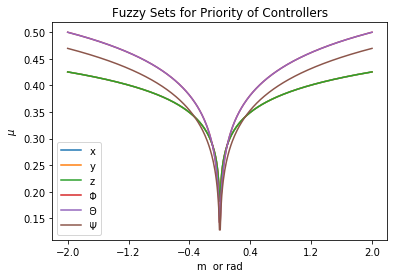

In [594]:
index =["x", "y", "z", "Φ", "Θ", "Ψ"]
num = 6

# Beginning of interval
boi = -2
# End of interval
eoi = 2
# Range of interval
roi = eoi - boi

ref = np.linspace(boi,eoi,roi*100)
PR = np.array([gbellmf(a=9 , b=-0.1, c=0, ref_set=ref),
               gbellmf(a=9 , b=-0.1, c=0, ref_set=ref),
               gbellmf(a=9 , b=-0.1, c=0, ref_set=ref),
               gbellmf(a=2 , b=-0.15, c=0, ref_set=ref),
               gbellmf(a=2 , b=-0.15, c=0, ref_set=ref),
               gbellmf(a=3 , b=-0.15, c=0, ref_set=ref)])

for i in range(num):
    plt.plot(ref, PR[i].series(), label=index[i]) 
    
plt.xticks(np.arange(boi, eoi+ roi/(num-1), roi/(num-1)))
plt.xlabel("m  or rad")
plt.ylabel("$\mu$")
plt.title(r"Fuzzy Sets for Priority of Controllers")
plt.legend();

##### Fuzzy sets for error in z direction and speed in z direction

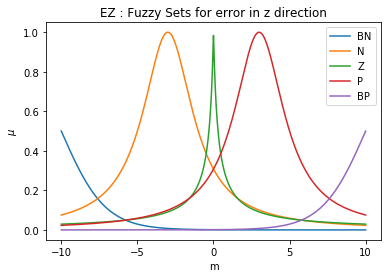

In [595]:
index =["BN", "N", "Z","P", "BP"]
num = 5

# Beginning of interval
boi = -10
# End of interval
eoi = 10
# Range of interval
roi = eoi - boi

ref = np.linspace(boi,eoi,roi*100)
EZ = np.array([sigmf(b=-10, c=-0.7, ref_set=ref),
              gbellmf(a=2 , b=1, c=-3, ref_set=ref),
              gbellmf(a=0.3 , b=0.5, c=0, ref_set=ref),
              gbellmf(a=2 , b=1, c=3, ref_set=ref),
              sigmf(b=10, c= 0.7, ref_set=ref)])

for i in range(num):
    plt.plot(ref, EZ[i].series(), label=index[i]) 
    
plt.xticks(np.arange(boi, eoi+ roi/(num-1), roi/(num-1)))
plt.xlabel("m")
plt.ylabel("$\mu$")
plt.title(r"EZ : Fuzzy Sets for error in z direction")
plt.legend();

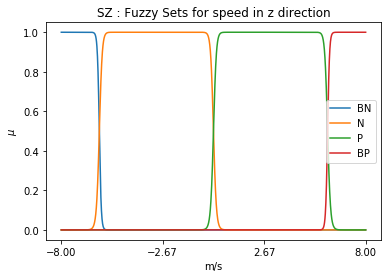

In [596]:
index =["BN", "N", "P", "BP"]
num = 4

# Beginning of interval
boi = -8
# End of interval
eoi = 8
# Range of interval
roi = eoi - boi

ref = np.linspace(boi,eoi,roi*100)
SZ = np.array([sigmf(b=-6,    c=-20, ref_set=ref),
              gbellmf(a=3 , b=20, c=-3, ref_set=ref),
              gbellmf(a=3 , b=20, c=3, ref_set=ref),
              sigmf(b=6,    c= 20, ref_set=ref)])

for i in range(num):
    plt.plot(ref, SZ[i].series(), label=index[i]) 
    
plt.xticks(np.arange(boi, eoi+ roi/(num-1), roi/(num-1)))
plt.xlabel("m/s")
plt.ylabel("$\mu$")
plt.title(r"SZ : Fuzzy Sets for speed in z direction")
plt.legend();

##### Fuzzy sets for error in Ψ direction and speed in Ψ direction 

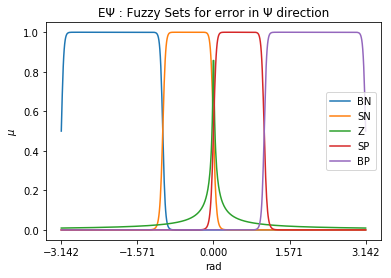

In [597]:
index =["BN","SN", "Z", "SP", "BP"]
num = 5

# Beginning of interval
boi = -np.pi
# End of interval
eoi = np.pi
# Range of interval
roi = eoi - boi

ref = np.linspace(boi,eoi,int(roi*100))
EΨ = np.array([gbellmf(a=np.pi/3, b=20,  c=-np.pi*2/3, ref_set=ref),
              gbellmf(a=np.pi/6, b=9,   c=-np.pi/6, ref_set=ref),
              gbellmf(a=0.03,    b=0.5, c=0, ref_set=ref),
              gbellmf(a=np.pi/6, b=9,   c= np.pi/6 , ref_set=ref),
              gbellmf(a=np.pi/3, b=20,  c= np.pi*2/3 , ref_set=ref)])

for i in range(num):
    plt.plot(ref, EΨ[i].series(), label=index[i]) 
    
plt.xticks(np.arange(boi, eoi+ roi/(num-1), roi/(num-1)))
plt.xlabel("rad")
plt.ylabel("$\mu$")
plt.title(r"EΨ : Fuzzy Sets for error in Ψ direction")
plt.legend();

Max Angular Speed : 200°/s = 3.4 rad/s (PHANTOM 4 SPECS)

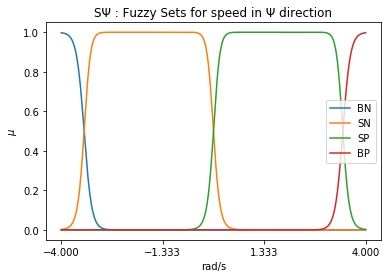

In [598]:
index =["BN","SN", "SP", "BP"]
num = 4

# Beginning of interval
boi = -4
# End of interval
eoi = 4
# Range of interval
roi = eoi - boi

ref = np.linspace(boi,eoi,roi*100)
SΨ = np.array([sigmf( b=-3.4, c=-10, ref_set=ref),
              gbellmf(a=1.7, b=10, c=-1.7, ref_set=ref),
              gbellmf(a=1.7, b=10, c=1.7, ref_set=ref),
              sigmf( b= 3.4, c=10 , ref_set=ref)])

for i in range(num):
    plt.plot(ref, SΨ[i].series(), label=index[i]) 
    
plt.xticks(np.arange(boi, eoi+ roi/(num-1), roi/(num-1)))
plt.xlabel("rad/s")
plt.ylabel("$\mu$")
plt.title(r"SΨ : Fuzzy Sets for speed in Ψ direction")
plt.legend();

### 2.2. Rule Base

Basic Flight movements of a Quadcopter (MQ):

In [599]:
MQ = np.array([[ 1,  1,  1,  1], # z:+
               [ 1, -1,  1, -1], # Ψ:+
               [-1,  0,  1,  0], # x:+  Θ:+
               [ 0,  1,  0, -1]])# y:+  Φ:-

neutral_output = np.array([201, 201, 201, 201])

In [677]:
                      #                   SX 
                      #    BN         N         P        BP
rule_base_x= np.array([[ 5*MQ[2],  5*MQ[2],  4*MQ[2], -4*MQ[2]], # BN       
                       [ 3*MQ[2],  3*MQ[2],  2*MQ[2], -1*MQ[2]], # N  
                       [ 2*MQ[2],  1*MQ[2], -1*MQ[2], -2*MQ[2]], # Z  EX
                       [ 1*MQ[2], -2*MQ[2], -3*MQ[2], -3*MQ[2]], # P  
                       [ 4*MQ[2], -4*MQ[2], -5*MQ[2], -5*MQ[2]]])# BP 
#===========================================================================
                      #                   SY 
                      #    BN         N         P        BP
rule_base_y=  np.array([[ 5*MQ[3],  5*MQ[3],  4*MQ[3], -4*MQ[3]], # BN       
                        [ 3*MQ[3],  3*MQ[3],  2*MQ[3], -1*MQ[3]], # N  
                        [ 2*MQ[3],  1*MQ[3], -1*MQ[3], -2*MQ[3]], # Z  EY
                        [ 1*MQ[3], -2*MQ[3], -3*MQ[3], -3*MQ[3]], # P  
                        [ 4*MQ[3], -4*MQ[3], -5*MQ[3], -5*MQ[3]]])# BP 
#===========================================================================
                      #                   SZ 
                      #    BN         N         P        BP
rule_base_z= np.array([[ 30*MQ[0],  25*MQ[0],  20*MQ[0],  20*MQ[0]], # BN       
                       [ 20*MQ[0],  15*MQ[0],  10*MQ[0], -10*MQ[0]], # N  
                       [ 10*MQ[0],   1*MQ[0],  -1*MQ[0], -10*MQ[0]], # Z  EZ
                       [ 10*MQ[0], -10*MQ[0], -15*MQ[0], -20*MQ[0]], # P  
                       [-20*MQ[0], -20*MQ[0], -25*MQ[0], -30*MQ[0]]])# BP  
#===========================================================================
                     #                   SΦ 
                     #      BN       N         P        BP
rule_base_Φ=-np.array([[20*MQ[3], 10*MQ[3], 10*MQ[3], -5*MQ[3]], # BN       
                       [20*MQ[3], 10*MQ[3],  5*MQ[3],-10*MQ[3]], # N  
                       [ 2*MQ[3],  1*MQ[3], -1*MQ[3], -2*MQ[3]], # Z  EΦ
                       [10*MQ[3], -5*MQ[3],-10*MQ[3],-20*MQ[3]], # P  
                       [ 5*MQ[3],-10*MQ[3],-10*MQ[3],-20*MQ[3]]])# BP 
#===========================================================================
                     #                   SΘ 
                     #      BN       N         P        BP
rule_base_Θ= np.array([[20*MQ[2], 10*MQ[2], 10*MQ[2], -5*MQ[2]],# BN       
                       [10*MQ[2],  5*MQ[2],  1*MQ[2], -5*MQ[2]],# N  
                       [ 2*MQ[2],  1*MQ[2], -1*MQ[2], -2*MQ[2]],# Z  EΘ
                       [ 5*MQ[2], -1*MQ[2], -5*MQ[2],-10*MQ[2]], # P  
                       [ 5*MQ[2],-10*MQ[2],-10*MQ[2],-20*MQ[2]]])# BP  
#===========================================================================
                     #                   SΨ 
                     #      BN       N         P        BP
rule_base_Ψ= np.array([[30*MQ[1], 20*MQ[1], 10*MQ[1],-30*MQ[1]], # BN       
                       [30*MQ[1], 20*MQ[1],  1*MQ[1],-20*MQ[1]], # N  
                       [0*MQ[1],  0*MQ[1],  0*MQ[1],-0*MQ[1]], # Z  EΨ
                       [20*MQ[1], -1*MQ[1],-20*MQ[1],-30*MQ[1]], # P  
                       [30*MQ[1],-10*MQ[1],-20*MQ[1],-30*MQ[1]]])# BP  

In [678]:
def fuzzy_controller(error, speed, e_set, s_set, rule_base):
    # 1. Degrees of compatibility 
    # 2. Firing Strength: 
    u = np.array([[e_set[i].doc(error)*s_set[j].doc(speed)
                   for j in range(len(s_set))]
                  for i in range(len(e_set))])

    # 3. Qualified (induced) consequent MFs : Algebraic Product implication
    result = np.array( [[rule_base[i][j]*u[i,j] 
                          for j in range(len(s_set))]
                         for i in range(len(e_set))])
#     print(result)
    # 5. defuzzification : COA
    result  = np.sum(result,axis=(0,1))/np.sum(u)

    return result

In [679]:
def controller(qr, #quad_rotor
               setpoint_x = 1,
               setpoint_y = 1,
               setpoint_z = 1, 
               setpoint_Φ = 0, 
               setpoint_Θ = 0, 
               setpoint_Ψ = 0):
    
    R = qr.R
    invR = R.T
    
    x = qr.x[-1]
    xd = qr.IMU_xd[-1]
#     x_error = x - setpoint_x
    
    y = qr.y[-1]
    yd = qr.IMU_yd[-1]
#     y_error = y - setpoint_y
    
    z = qr.z[-1]
    zd = qr.IMU_zd[-1]
#     z_error = z - setpoint_z
    
    x_error, y_error, z_error = np.dot(invR,[ x-setpoint_x,  y-setpoint_y, z-setpoint_z]) 
    

    
    Φ = qr.principal_value(qr.IMU_Φ[-1])
    Φd = qr.IMU_Φd[-1]
    Φ_error = qr.principal_value(Φ - setpoint_Φ)
    
    Θ = qr.principal_value(qr.IMU_Θ[-1])
    Θd = qr.IMU_Θd[-1]
    Θ_error = qr.principal_value(Θ - setpoint_Θ)
    
    Ψ = qr.principal_value(qr.IMU_Ψ[-1])
    Ψd = qr.IMU_Ψd[-1]
    Ψ_error = qr.principal_value(Ψ - setpoint_Ψ)
    
    result = neutral_output + fuzzy_controller(z_error, zd, EZ, SZ, rule_base_z) + \
                            (  fuzzy_controller(x_error, xd, EZ, SZ, rule_base_x)*PR[0].doc(x_error) +
                               fuzzy_controller(y_error, yd, EZ, SZ, rule_base_y)*PR[1].doc(y_error) +
                               fuzzy_controller(Φ_error, Φd, EΨ, SΨ, rule_base_Φ)*PR[3].doc(Φ_error) +
                               fuzzy_controller(Θ_error, Θd, EΨ, SΨ, rule_base_Θ)*PR[4].doc(Θ_error) +
                               fuzzy_controller(Ψ_error, Ψd, EΨ, SΨ, rule_base_Ψ)*PR[5].doc(Ψ_error) 
                              ) / (PR[0].doc(x_error) +
                                   PR[1].doc(y_error) +
                                   PR[3].doc(Φ_error) +
                                   PR[4].doc(Θ_error) +
                                   PR[5].doc(Ψ_error) )
   
    return result   

In [680]:
q.simulate(Dx=0.01,Tf=10, controller=controller,Θ=0,Ψ=0,Φ=0)

FloatProgress(value=0.0, bar_style='info', description='Run:0%')

D:\Programs\Microsoft Visual Studio\Shared\Anaconda3_64\envs\env2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning:

divide by zero encountered in double_scalars



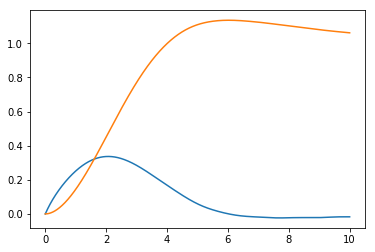

In [681]:
# plt.plot(q.time, q.xd)
# plt.plot(q.time, q.x)
# plt.plot(q.time, q.yd)
# plt.plot(q.time, q.y)
plt.plot(q.time, q.zd)
plt.plot(q.time, q.z)

# setp = np.ones(shape=q.time.shape)*10
# plt.plot(q.time,setp)

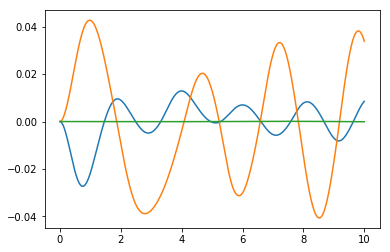

In [682]:
plt.plot(q.time, q.Φ)
# plt.plot(q.time, q.Φd)
plt.plot(q.time, q.Θ)
# plt.plot(q.time, q.Θd)
plt.plot(q.time, q.Ψ)
# plt.plot(q.time, q.Ψd) 
# setp = np.ones(shape=q.time.shape)*10
# plt.plot(q.time,setp)

In [683]:
cplot(rangex=[-1,2],rangey=[-1,2],rangez=[-1,2])